# ***import libs and data***

In [27]:
!pip install mlxtend

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
%matplotlib inline

Train_data = pd.read_csv('/content/drive/My Drive/Tianchi/used_car_train_20200313.csv', sep = ' ')
Test_data = pd.read_csv('/content/drive/My Drive/Tianchi/used_car_testA_20200313.csv', sep = ' ')
print(Train_data.shape, Test_data.shape)

(150000, 31) (50000, 30)


In [2]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [3]:
Test_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

# ***outliers process***

In [0]:
def outliers_proc(data, col_name, scale = 3):
  '''
  Clean outliers
  using box_plot(scale = 3)
  :param data: receive pandas data formate
  :param col_name: pandas column name
  :param scale: boxplot scale
  :return:
  more info about Tukey's test:
  https://www.zhihu.com/question/36172806
  '''
  def box_plot_outliers(data_ser, box_scale):
    '''
    clean outliers using boxplot
    Max: Q1-k(Q3-Q1)
    Min: Q3+k(Q3-Q1)
    k = 1.5 moderately outliers
    k = 3 extremely outliers
    :param data_ser: receive pandas Series
    :param box_scale: scale of boxplot
    :return:
    '''
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + iqr
    rule_low = (data_ser < val_low) #Bool for each value
    rule_up = (data_ser > val_up)
    return (rule_low, rule_up), (val_low, val_up)

  data_n = data.copy()
  data_series = data_n[col_name]
  rule, value = box_plot_outliers(data_series, box_scale = scale)
  #！布尔索引，[rule[0] | rule[1]]是每个power的TrueorFalse的list
  #首先创建一个150000个数（power的记录数量）的列表，然后只要True的数字
  index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
  print('Delete number is: {}'.format(len(index)))
  data_n = data_n.drop(index)
  data_n.reset_index(drop = True, inplace = True)
  print('Now column number is: {}'.format(data_n.shape[0]))
  #布尔索引again
  index_low = np.arange(data_series.shape[0])[rule[0]]
  outliers = data_series.iloc[index_low]
  print('Description of data less than the lower bound is:')
  print(pd.Series(outliers).describe)
  index_up = np.arange(data_series.shape[0])[rule[1]]
  outliers = data_series.iloc[index_up]
  print('Description of data larger than the upper bound is:')
  print(pd.Series(outliers).describe())

  fig, ax = plt.subplots(1,2,figsize = (10, 7))
  sns.boxplot(
      y = data[col_name],
      data = data,
      palette = 'Set1',
      ax = ax[0],
  )
  sns.boxplot(
      y = data_n[col_name],
      data = data_n,
      palette = 'Set1',
      ax = ax[1],
  )
  return data_n


Delete number is: 0
Now column number is: 149037
Description of data less than the lower bound is:
<bound method NDFrame.describe of Series([], Name: power, dtype: int64)>
Description of data larger than the upper bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64


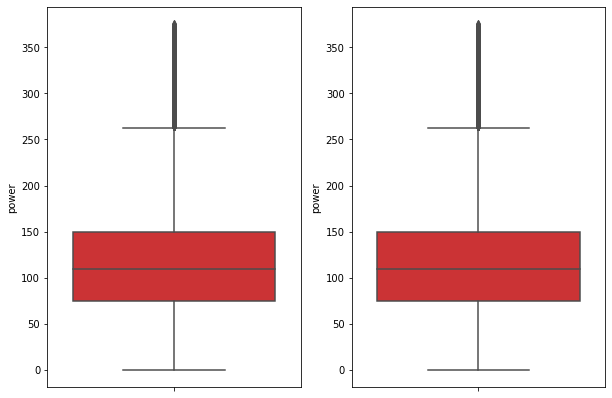

In [41]:
#可以删掉一些异常数据，自行判断 但是test的数据不能删
Train_data = outliers_proc(
    Train_data,
    'power',
    scale = 3,
)

# ***Feature Generation***

In [6]:
#训练集和测试集放在一起，方便构造特征
Train_data['train'] = 1
Test_data['train'] = 0
data = pd.concat([Train_data, Test_data], ignore_index = True)
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,regDate,regionCode,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,0,60,1850.0,20040402,1046,0,1,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,0,0,3600.0,20030301,4366,0,1,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,0,163,6222.0,20040403,2806,0,1,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,0,193,2400.0,19960908,434,0,1,45.687478,4.492574,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,0,68,5200.0,20120103,6977,0,1,44.383511,2.031433,-1.896240,0.910783,0.931110,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,199995,4.0,4,20160320,0.0,0.0,15.0,4.0,20903,0.0,0,116,NaN,19960503,3219,0,0,45.621391,5.958453,-5.978511,1.303174,-1.207191,-1.981240,-0.357695,-0.918571,0.774826,-2.021739,0.284664,0.130044,0.049833,0.028807,0.004616
199033,199996,0.0,0,20160329,0.0,0.0,15.0,0.0,708,0.0,0,75,NaN,19991011,1857,0,0,43.935162,4.476841,-3.913825,1.759524,-2.075658,-1.154847,0.169073,-0.841710,1.328253,-1.292675,0.268101,0.108095,0.066039,0.025468,0.025971
199034,199997,0.0,1,20160305,1.0,1.0,15.0,49.0,6693,0.0,0,224,NaN,20040412,3452,0,0,46.537137,4.170806,-4.639065,0.654713,1.137756,-1.390531,0.254420,0.388595,-0.704689,-1.480710,0.269432,0.105724,0.117652,0.057479,0.015669
199035,199998,0.0,1,20160404,0.0,1.0,15.0,27.0,96900,0.0,0,334,NaN,20020008,1998,0,0,46.771359,-3.296814,1.833504,-2.828687,2.465630,-0.911682,-2.057353,0.243566,-1.277411,-0.404881,0.261152,0.000490,0.137366,0.086216,0.051383


In [0]:
#使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说与价格呈反比
#不过要注意，数据里面有时间出错的格式，所以我们要 errors = 'coerce'将无效值强制变为Nan
data['used_time'] = (
    pd.to_datetime(data['creatDate'],format = '%Y%m%d',errors = 'coerce')-
    pd.to_datetime(data['regDate'],format = '%Y%m%d',errors = 'coerce')
)

In [8]:
#看一下空数据，有15k个样本是有问题的，可以选择清除，也可以选择放着
#这里不建议清除，因为删除缺失数据占总样本量过大，7.5%
#我们可以先放着，因为我们用XGBoost决策树，本身就能处理缺失值
data['used_time'].isnull().sum()

15072

In [0]:
#从邮编中提取城市信息，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

In [0]:
#计算某**品牌**的销售统计额，还可以计算其他特征的统计量
#这里以train的数据计算统计量
Train_gb = Train_data.groupby('brand')
all_info = {}
for kind, kind_data in Train_gb:
  info = {}
  #kind_data是pandas的dataframe
  kind_data = kind_data[kind_data['price'] > 0] #布尔索引
  #print(kind_data.price)
  info['brand_amount'] = len(kind_data) #字典添加
  info['brand_price_max'] = kind_data.price.max()
  info['brand_price_median'] = kind_data.price.median()
  info['brand_price_sum'] = kind_data.price.sum()
  info['brand_price_min'] = kind_data.price.min()
  info['brand_price_std'] = kind_data.price.std()
  info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1))
  all_info[kind] = info

brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns = {'index': 'brand'}) # index列名改为brand
data = data.merge(brand_fe, how = 'left', on = 'brand')
#left：以data为准，用brand这一列merge



In [0]:
#groupby用法
#df = pd.DataFrame({'key1':list('aabba'),
#                  'key2': ['one','two','one','two','one'],
#                  'data1': np.random.randn(5),
#                  'data2': np.random.randn(5)})
#df
#grouped=df.groupby(df['key1'])
#for name, group in df.groupby('key1'):
#        print (name)
#        print (group)

In [12]:
# 数据分桶 以 power 为例
# 这时候缺失值也进桶了，分桶好处：
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
#bin:[0, 10,20,30,40,50,60...300] 分成不同区间
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
#power_bin 是第几桶的意思 cut函数：按区间分数据
data[['power_bin', 'power']]



,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68
...,...,...
199032,11.0,116
199033,7.0,75
199034,22.0,224
199035,NaN,334


In [0]:
#删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis = 1)

In [14]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'kilometer',
       'model', 'name', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_sum', 'brand_price_min', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [0]:
#目前的数据已经可以给树模型了，导入一下
data.to_csv('data_for_tree.csv', index = 0)

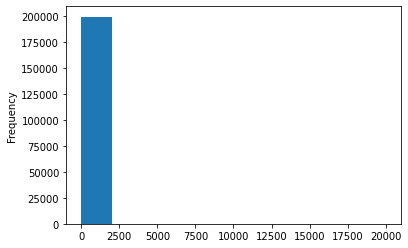

In [16]:
#也可以再构造一份特征给LR或者NN使用
#看一下数据分布
data['power'].plot.hist()

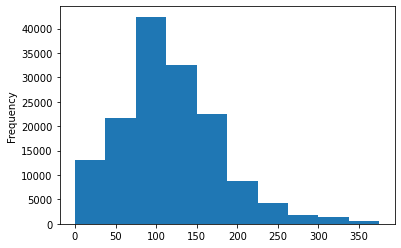

In [17]:
# 我们刚刚已经对 train 进行异常值处理了，但是现在还有这么奇怪的分布是因为 test 中的 power 异常值，
# 所以我们其实刚刚 train 中的 power 异常值不删为好，可以用长尾分布截断来代替
Train_data['power'].plot.hist()

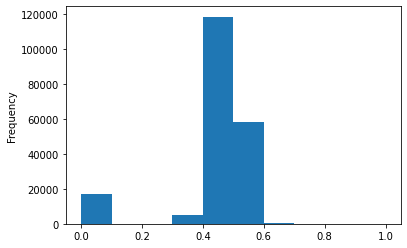

In [18]:
#我们对其取log再归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1)
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

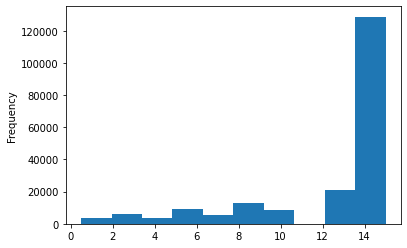

In [19]:
# km 的比较正常，应该是已经做过分桶了
data['kilometer'].plot.hist()

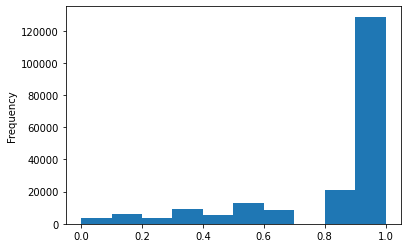

In [20]:
# 所以我们可以直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [0]:
# 除此之外 还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 不一一举例，直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

In [0]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [22]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'kilometer',
       'model', 'name', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_sum', 'brand_price_min', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [23]:
data

,SaleID,bodyType,brand,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_sum,brand_price_min,brand_price_std,brand_price_average,power_bin
0,0,1.0,6,0.0,0.0,0.827586,30.0,736,0.0,0,0.415091,1850.0,0,1,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,4385 days,1,0.324125,0.340786,0.032075,0.209684,0.002064,0.207660,0.081629,5.0
1,1,2.0,1,0.0,0.0,1.000000,40.0,2262,-,0,0.000000,3600.0,0,1,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,4757 days,4,0.434341,0.835230,0.205623,0.713985,0.004128,0.437002,0.257297,NaN
2,2,1.0,15,0.0,0.0,0.827586,115.0,14874,0.0,0,0.514954,6222.0,0,1,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,4382 days,2,0.046117,0.433578,0.284906,0.082533,0.091847,0.252362,0.281827,16.0
3,3,0.0,10,0.0,1.0,1.000000,109.0,71865,0.0,0,0.531917,2400.0,0,1,45.687478,4.492574,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,7125 days,,0.445099,0.926889,0.160377,0.650591,0.004128,0.398447,0.225207,19.0
4,4,1.0,5,0.0,0.0,0.310345,110.0,111080,0.0,0,0.427535,5200.0,0,1,44.383511,2.031433,-1.896240,0.910783,0.931110,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,1531 days,6,0.148090,0.294545,0.050943,0.088524,0.009288,0.144579,0.073017,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,199995,4.0,4,0.0,0.0,1.000000,4.0,20903,0.0,0,0.480856,NaN,0,0,45.621391,5.958453,-5.978511,1.303174,-1.207191,-1.981240,-0.357695,-0.918571,0.774826,-2.021739,0.284664,0.130044,0.049833,0.028807,0.004616,7261 days,3,0.527244,1.000000,0.190528,0.795943,0.001032,0.390425,0.233660,11.0
199033,199996,0.0,0,0.0,0.0,1.000000,0.0,708,0.0,0,0.437292,NaN,0,0,43.935162,4.476841,-3.913825,1.759524,-2.075658,-1.154847,0.169073,-0.841710,1.328253,-1.292675,0.268101,0.108095,0.066039,0.025468,0.025971,6014 days,1,1.000000,0.675599,0.084868,1.000000,0.002064,0.295692,0.143864,7.0
199034,199997,0.0,1,1.0,1.0,1.000000,49.0,6693,0.0,0,0.546885,NaN,0,0,46.537137,4.170806,-4.639065,0.654713,1.137756,-1.390531,0.254420,0.388595,-0.704689,-1.480710,0.269432,0.105724,0.117652,0.057479,0.015669,4345 days,3,0.434341,0.835230,0.205623,0.713985,0.004128,0.437002,0.257297,22.0
199035,199998,0.0,1,0.0,1.0,1.000000,27.0,96900,0.0,0,0.587076,NaN,0,0,46.771359,-3.296814,1.833504,-2.828687,2.465630,-0.911682,-2.057353,0.243566,-1.277411,-0.404881,0.261152,0.000490,0.137366,0.086216,0.051383,NaT,1,0.434341,0.835230,0.205623,0.713985,0.004128,0.437002,0.257297,NaN


In [0]:
# 这份数据可以给 LR 用
data.to_csv('data_for_lr.csv', index=0)

# ***特征筛选***

## ***过滤式***

In [25]:
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


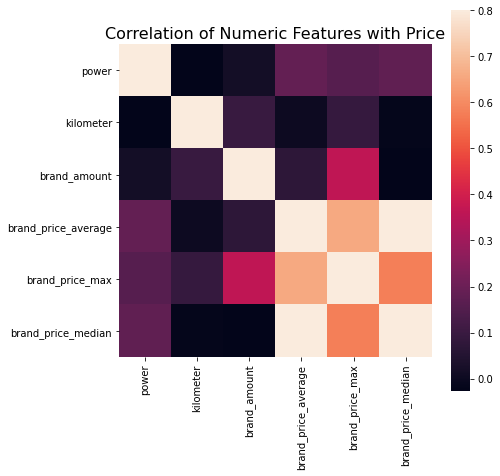

In [26]:
# 也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

## ***包裹式***

In [0]:
# k_feature 太大会很难跑
'''
包裹式特征选择直接把最终要使用的学习器的性能作为特征子集的评价准则。
包裹式特征选择的目的就是为给定学习器选择最有利于其性能，“量身定做”的特征子集。
由于包裹式特征选择方法直接针对给定学习器进行优化，因此从最终学习器性能看，包裹式特征选择比过滤式特征选择更好。
另一方面，特征选择过程中需多次训练学习器，因此包裹式特征选择的计算开销通常比过滤式特征选择大得多。
包裹法中，特征子集的搜索问题，最容易想到的办法是穷举法，
还可以在拉斯维加斯方法框架下使用随机策略进行子集搜索（Las Vegas Wrapper，LVW）。
但是由于LVW算法中特征子集搜索采用了随机策略，每次特征子集评价都需要训练学习器，
计算开销很大，如果初始特征数很多，算法可能运行很长时间都达不到停止条件，若有运行时间限制，可能给不出解。
'''
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

In [0]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()